In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [36]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, ReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pdb import set_trace
%matplotlib inline

In [5]:
from pathlib import Path
path = Path("simulator-data")

In [6]:
df = pd.read_csv(path/"driving_log.csv")

In [7]:
df.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [8]:
images = [cv2.cvtColor(cv2.imread(str(path/img)), cv2.COLOR_BGR2RGB) for img in df['center'][:250:10]]

In [9]:
images[0].shape, images[-1].shape

((160, 320, 3), (160, 320, 3))

In [10]:
fs = [path/img for img in df['center'][:25]]

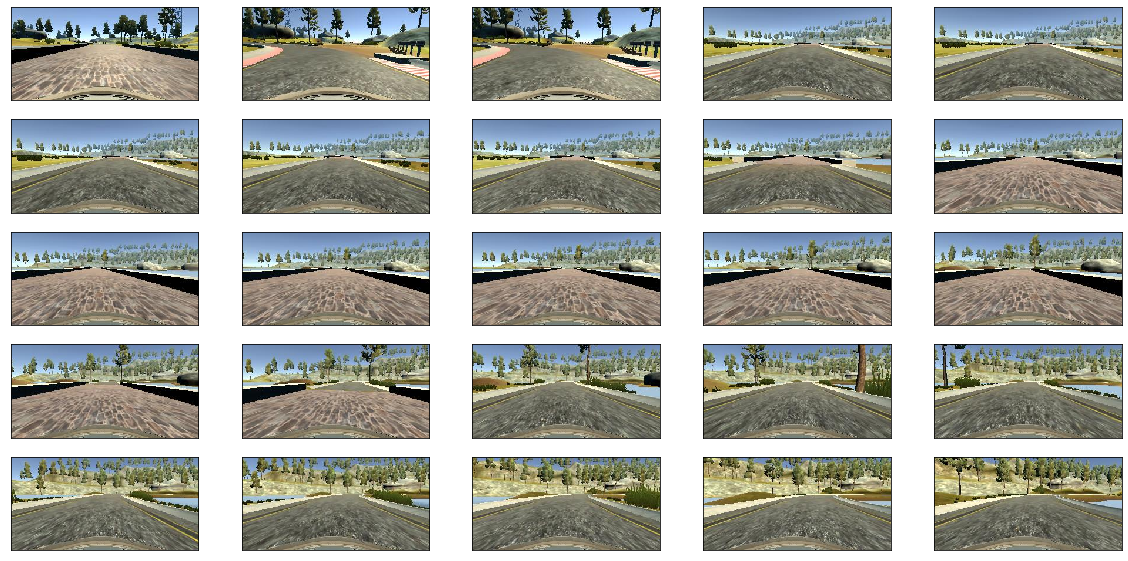

In [11]:
plt.figure(figsize=(20,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])
plt.show()

In [40]:
def preprocess(image, measurement, correction_factor, flip=1.0):
    img, label = np.copy(image), np.copy(measurement)
    label += 0.225 * correction_factor
    img = img / 255 - 0.5
    if np.random.uniform() < flip:
        img = np.fliplr(img)
        label = -label
    return img, label

In [41]:
def load_image(img):
    image = cv2.cvtColor(cv2.imread(str(path/img)), cv2.COLOR_BGR2RGB)
    # crop off top 70 and bottom 25 pixels
    return image[70:-25,...]

In [42]:
def get_batch(rows):
    images, targets = [], []
    for i in range(rows.shape[0]):
        idx = np.random.choice(3)
        img = load_image(rows[i,idx].strip())
        tgt = rows[i,3] # 'steering'
        if idx == 0: correction_factor = 0
        elif idx == 1: correction_factor = 1
        else: correction_factor = -1
        img, tgt = preprocess(img, tgt, correction_factor, flip=0.5)
        images.append(img)
        targets.append(tgt)
    return np.array(images), np.array(targets)

In [43]:
split = int(df.shape[0]*0.8)

In [44]:
def train_epoch(model, df, bs=8):
    losses = []
    n_samples = df.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    for i in range(n_samples // bs - 1):
        images, targets = get_batch(df.iloc[indices[bs*i:bs*(i+1)]].values)
        for image in images:
            image = tf.image.adjust_brightness(image, np.random.uniform(0.6, 1.0))
            image = tf.image.adjust_saturation(image, np.random.uniform(0.75, 1.5))
        hist = model.fit(images, targets, verbose=0)
        losses.append(hist.history['loss'])
        if i % 200 == 0 and i > 0:
            print(np.mean(losses))
    return np.mean(losses)

In [45]:
def valid_epoch(model, df, bs=8):
    losses = []
    n_samples = df.shape[0]
    indices = np.arange(n_samples)
    for i in range(n_samples // bs - 1):
        idx = indices[bs*i:bs*(i+1)]
        images = np.array([(load_image(df.iloc[j,0].strip()) / 255 - 0.5) for j in idx])
        targets = np.array([df.iloc[j,3] for j in idx])
        outputs = model.predict(images)
        losses.append(np.mean((targets - outputs)**2))
    return np.mean(losses)

In [54]:
IMG_HEIGHT, IMG_WIDTH = 160-(70+25), 320

model = Sequential([
    Conv2D(32, 7, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(64, 5, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(128, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(256, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(256, 3, padding='same', activation='relu'),
    Flatten(),
    BatchNormalization(),
    ReLU(),
    Dropout(0.3),
    Dense(512, activation='relu'),
    ReLU(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1)
])

In [55]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
              loss='mean_squared_error')

In [ ]:
train_losses = []
val_losses = []
for epoch in range(100):
    loss = train_epoch(model, df[:split])
    train_losses.append(loss)
    loss = valid_epoch(model, df[split:])
    val_losses.append(loss)
    print("EPOCH {}: {:.5f}, {:.5f}".format(epoch, train_losses[-1], val_losses[-1]))
    if epoch % 5 == 0 and epoch > 0:
        model.save('model{}.h5'.format(epoch))

0.4926808839246853
0.27080882145579616
0.19261360883529913
0.15326211365990888
EPOCH 0: 0.15310, 0.01961
0.03137065874718463
0.030150884703182595
0.029759797351295362
0.028570081009651613
EPOCH 1: 0.02856, 0.02652
0.02374672579500287
0.02421475725917336
0.02471751390302402
0.024128312231930956
EPOCH 2: 0.02412, 0.02720
0.023829940167853413
0.02375742736239999
0.0244477427639718
0.024668962725225403
EPOCH 3: 0.02466, 0.02805
0.024802123161672213
0.024178105096409372
0.023483147279060323
0.0233767404082637
EPOCH 4: 0.02336, 0.02352
0.023909156632364092
0.022156071931616103
0.021480745234574734
0.02138307469998127
EPOCH 5: 0.02136, 0.02674
0.022459146287523914
0.021147122353482574
0.021519748132967215
0.021328349200980774
EPOCH 6: 0.02132, 0.03403
0.02148249468288908
0.02041461880544103
0.020681557667049613
0.020827626832150455
EPOCH 7: 0.02083, 0.03374
0.02164743446272367
0.022821053510132312
0.02241217307072325
0.02203304404956748
EPOCH 8: 0.02205, 0.04482
0.02204150773714579
0.02257087

In [46]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 65, 320, 32)       896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 160, 32)       0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 160, 32)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 160, 64)       18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 80, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 16, 80, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 80, 128)      

In [26]:
model.save('model.h5')

In [40]:
history = model2.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

NameError: name 'train_images' is not defined

In [ ]:
acc = history.history['mse']
val_acc = history.history['val_mse']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training MSE')
plt.plot(epochs_range, val_acc, label='Validation MSE')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from keras.models import Model
import matplotlib.pyplot as plt

history_object = model.fit_generator(train_generator, samples_per_epoch =
    len(train_samples), validation_data = 
    validation_generator,
    nb_val_samples = len(validation_samples), 
    nb_epoch=5, verbose=1)

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [ ]:
import os
import csv

samples = []
with open('./driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

import cv2
import numpy as np
import sklearn

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = './IMG/'+batch_sample[0].split('/')[-1]
                center_image = cv2.imread(name)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

# Set our batch size
batch_size=32

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)

ch, row, col = 3, 80, 320  # Trimmed image format

model = Sequential()
# Preprocess incoming data, centered around zero with small standard deviation 
model.add(Lambda(lambda x: x/127.5 - 1.,
        input_shape=(ch, row, col),
        output_shape=(ch, row, col)))
model.add(... finish defining the rest of your model architecture here ...)

model.compile(loss='mse', optimizer='adam')
model.fit_generator(train_generator, /
            steps_per_epoch=ceil(len(train_samples)/batch_size), /
            validation_data=validation_generator, /
            validation_steps=ceil(len(validation_samples)/batch_size), /
            epochs=5, verbose=1)